## Save saliency maps

At first, we compute all four supported saliency methods for a subset of 5 images of imagenet. It can not be run in this notebook, as Imegenet validation set is too alrge for github. The commented lines were run locally. 

The original images are the following:

In [1]:
from save_all_grad_maps import *
import matplotlib.image as mpimg
import cv2
sample_loader = get_sample_loader(batch_size=5)

In [2]:
def plot_batch(batch):
    (ch, r, c) = batch[0].size()

    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    for idx in range(0, columns * rows):
        image = unnormalize(batch[idx, :, :, :])
        img = [[[image[i, k, j] for i in range(ch)] for j in range(c)] for k in range(r)]
        ax = fig.add_subplot(rows, columns, idx + 1)
        plt.imshow(img)

    plt.show()

def plot_batch_saliency(batch):
    (ch, r, c) = batch[0].size()

    fig = plt.figure(figsize=(20, 20))
    columns = 5
    rows = 1
    for idx in range(0, columns * rows):
        image = batch[idx, :, :, :]
        img = [[[image[i, k, j] for i in range(ch)] for j in range(c)] for k in range(r)]
        ax = fig.add_subplot(rows, columns, idx + 1)
        plt.imshow(img)

    plt.show()
    

def load_im(im_name):
    img = mpimg.imread(os.path.join("results", "imagenet", im_name))
    
    return img

def load_bias_results(im_name):
    img = cv2.imread_color(os.path.join("results", "bias_experiment", "resnet", "images_pred", im_name))
    print(img.shape)
    return img

def save_bias_as_batch(im_names):
    batch = torch.zeros(len(im_names), 224, 224, 3)
    for i in range(len(im_names)):
        batch[i, :, :, :] = torch.tensor(load_bias_results(im_names[i]))

    return batch

def save_ims_as_batch(im_names):
    batch = torch.zeros(5, 224, 224, 3)
    for i in range(5):
        batch[i, :, :, :] = torch.tensor(load_im(im_names[i]))
    
    return batch


C:\Users\lintl\Anaconda3\lib\site-packages\torchvision\transforms\functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
C:\Users\lintl\Anaconda3\lib\site-packages\torchvision\transforms\functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


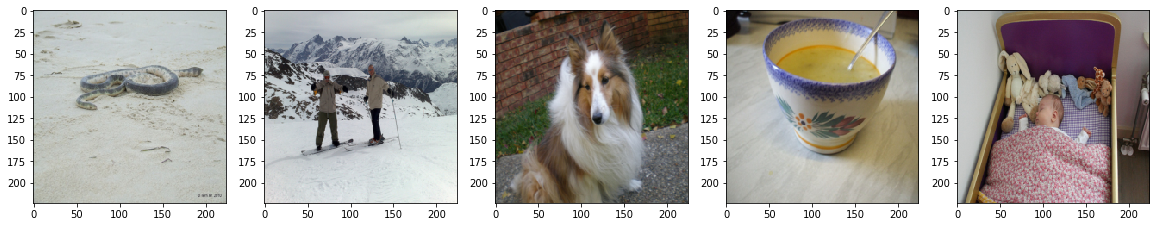

In [3]:
batch, _ = next(iter(sample_loader))
plot_batch(batch)

Respective Inputgradients:

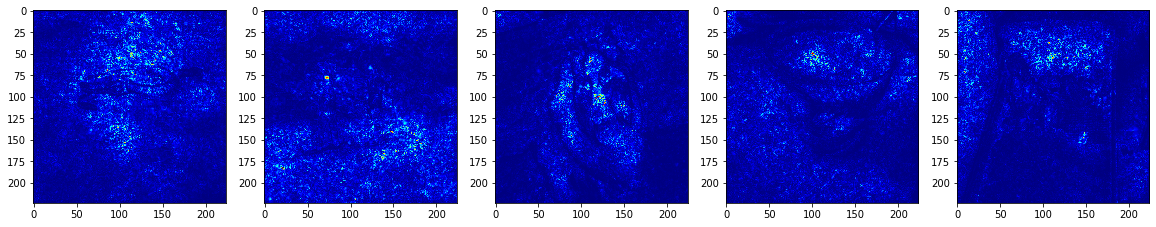

In [4]:
# Computes inputgrad on first 5 images
#compute_saliency_and_save(sample_loader, ["inputgrad"], 5, "layer4", "resnet18", "")
# load already precomputed images
im_names = ["inputgrad_resnet18_1.png","inputgrad_resnet18_2.png", "inputgrad_resnet18_3.png","inputgrad_resnet18_4.png", "inputgrad_resnet18_5.png" ]
batch = save_ims_as_batch(im_names).permute(0, 3, 1, 2)
plot_batch_saliency(batch)


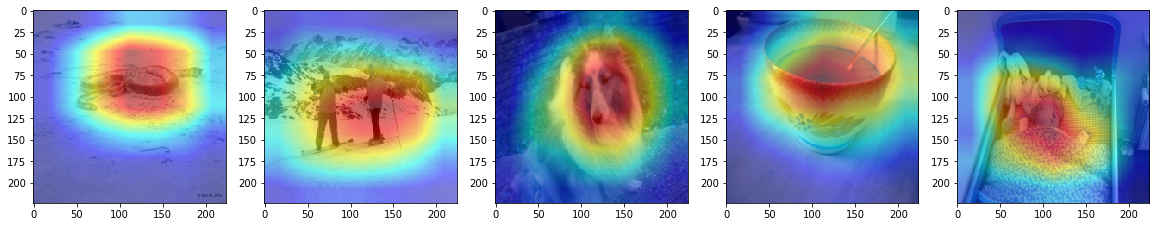

In [5]:
# Computes Gradcam on first 5 images
#compute_saliency_and_save(sample_loader, ["gradcam"], 5, "layer4", "resnet18", "")
# load already precomputed images
im_names = ["gradcam_resnet18_1.png","gradcam_resnet18_2.png", "gradcam_resnet18_3.png","gradcam_resnet18_4.png", "gradcam_resnet18_5.png" ]
batch = save_ims_as_batch(im_names).permute(0, 3, 1, 2)
plot_batch_saliency(batch)

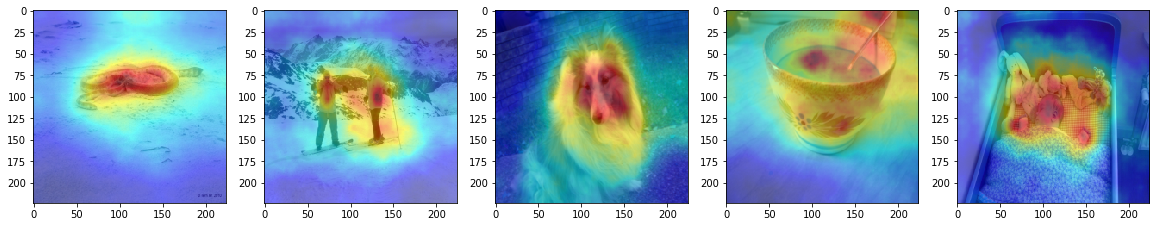

In [6]:
# Computes Fullgrad on first 5 images
#copute_saliency_and_save(sample_loader, ["fullgrad"], 5, "layer4", "resnet18", "")
# load already precomputed images

im_names = ["fullgrad_resnet18_1.png","fullgrad_resnet18_2.png", "fullgrad_resnet18_3.png","fullgrad_resnet18_4.png", "fullgrad_resnet18_5.png" ]
batch = save_ims_as_batch(im_names).permute(0, 3, 1, 2)
plot_batch_saliency(batch)

## Pixel Perturbation

Given time constraints we simply load our already obtained results from Lisa as pickle files for resnet18 and least salient removal. If you change file = "./results/pp_experiments//imagenet_resnet18_least_black500_full" with vgg instead of resnet or mean instead of black or most instead of least you can create


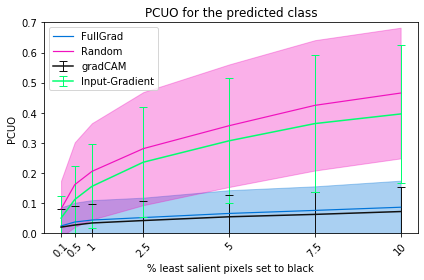

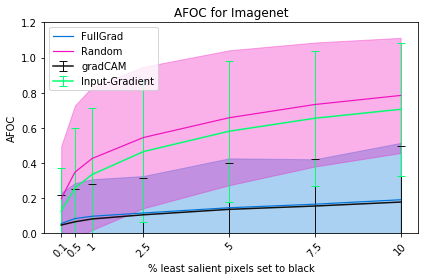

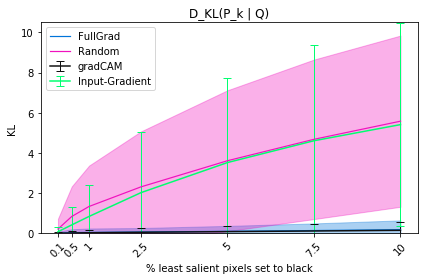

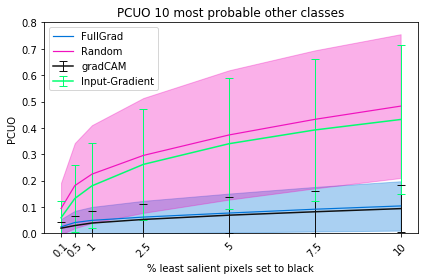

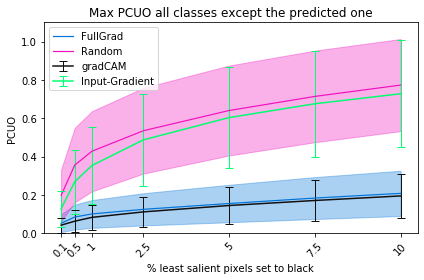

In [7]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Globals
metric = ["scores", "probs", "kl", "topk_other_scores", "topk_other_probs", "max_other_scores", "max_other_probs"]
title = ["PCUO for the predicted class", "AFOC for Imagenet", "D_KL(P_k | Q)", "PCUO 10 most probable other classes", "", "Max PCUO all classes except the predicted one", ""]
y_axis = ["PCUO", "AFOC", "KL", "PCUO", "", "PCUO", ""]
k = [0.1, 0.5, 1, 2.5, 5, 7.5, 10]
line_label = {"fullgrad": "FullGrad", "gradcam": "gradCAM", "random": "Random", "inputgrad": "Input-Gradient"}
colors = {"fullgrad": "#0074d9", "gradcam": "#111111", "random": "#f012be", "inputgrad": "#01ff70"}


def ceil_to_dec(digit):
    return np.ceil(digit * 10)/10


def plot_all_grads(results_dict, y_name, title_name, sorting, color, pkl_name, filename=None):
    plt.figure()
    axes = plt.gca()

    MAX_Y = 0
    for key, v in results_dict.items():
        if np.max(np.array(v[0]) + np.array(v[1])) > MAX_Y:
            MAX_Y = ceil_to_dec(np.max(np.array(v[0]) + np.array(v[1])))

    axes.set_ylim([0, MAX_Y])
    axes.set_xlabel("% " + sorting + " salient pixels set to " + color)
    axes.set_ylabel(y_name)
    plt.title(title_name)

    x_labels = k

    for key, v in results_dict.items():
        # Plot the mean and variance of the predictive distribution on the 100000 data points.
        if key == "fullgrad" or key == "random":
            plt.plot(k, np.array(v[0]), linewidth=1.2, label=line_label[key], color=colors[key])
            plt.fill_between(k, np.array(v[0]) - np.array(v[1]), np.array(v[0]) + np.array(v[1]), alpha=1/3, color=colors[key])
        else:
            plt.errorbar(k, np.array(v[0]), yerr=np.array(v[1]), label=line_label[key], capsize=4, color=colors[key], elinewidth=1)
    plt.xticks(k, x_labels, rotation=45)
    plt.tight_layout()
    plt.legend()
    # plt.savefig(filename + "_" + pkl_name +".png")
    plt.show()
    plt.close()


# Code to plot
file = "./results/pp_experiments//imagenet_resnet18_least_black500_full"
order = "least"  # or most
c = "black"  # or mean

with open(file+'.pkl', 'rb') as f:
    data = pickle.load(f)

for i in [0, 1, 2, 3, 5]:
    # print(i)
    # print(data[i].keys())
    plot_all_grads(data[i], y_name=y_axis[i], title_name=title[i], filename=metric[i], sorting=order, color=c, pkl_name=file)



## Bias Experiment 

In the folder biased_dataset we stored our scraped images from google image search. Preprocessing happened by hand and consisted of cropping background, resizing and removing not suitable images. 

In [8]:
from visualize_bias import*

visualize_bias.py visualizes the saliency maps of all validation images and some correctly and all incorrectly predicted training images. The biasexperiment itself is run in bias_experiment.py and according jobfiles in the folder /jobfiles show how exactly the pyfile can be called. Unfortunately due to time constraints we can not show the visualizations in here. But if the commands below are run, respective images are saved. The saved ones can be accessed in the folders. 

In [9]:
# save all validation images with targets, predictions and corresponding saliency map
# saliency_map_from_pretrained_model(dataloaders, config_dict, n_val=ARGS.n_val, data_type="val")
# save all misclassifications on the train set and n_correct correctly classified images
# saliency_map_from_pretrained_model(dataloaders, config_dict, n_correct = ARGS.n_correct, data_type="train")

Unfortunately, time constraints lead to the point where functions cant be run in here. The lines from above call all the prediction images with their corresponding saliency maps of fullgrad for their prediction class. They can all be found in \results\bias_experiment\vgg\images_pred and for resnet in \results\bias_experiment\resnet\images_pred. In the folder slurm_out one can find the training stats of all the frozen and unfrozen vgg and resnet models. 